In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Dec 13 07:42:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Model saving 
!pip install h5py pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install seqeval -qqq
# TODO: update this notebook to work with the latest version of transformers
!pip install -q transformers==2.11.0

     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 674 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.0 MB/s 
     |████████████████████████████████| 880 kB 85.0 MB/s 
     |████████████████████████████████| 7.5 MB 80.1 MB/s 


In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

#Importing Libraries

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, TensorBoard
from seqeval.metrics import classification_report
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import shutil
import pickle
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split


#Loading Data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Practicum/Datasets for Practicum/kinya_test_final.xlsx", skiprows=1).iloc[:,:]
df_kin = pd.read_csv("/content/drive/MyDrive/JP Morgan Chase/Report Models/Kinyarwanda/MBERT/Kinyarwanda_700.csv")

In [ ]:
## Sanity Check
df_kin.head()

,i would like to find a flight from charlotte to las vegas that makes a stop in st. louis,O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name,Nkeneye indege iva Charlotte yerekeza Las Vegas ariko ikabanza guca St Louis,O O O B-kuva.umujyi_izina O B-kugera.umujyi_izina I-kugera.umujyi_izina O O O B-guhagarara.umujyi_izina I-guhagarara.umujyi_izina
0,on april first i need a ticket from tacoma to ...,O B-depart_date.month_name B-depart_date.day_n...,Nkeneye itike y'indege iva Tacoma yeherekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...
1,on april first i need a flight going from phoe...,O B-depart_date.month_name B-depart_date.day_n...,Nkeneye itike y'indege iva Phoenix yerekeza Sa...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...
2,i would like a flight traveling one way from p...,O O O O O O B-round_trip I-round_trip O B-from...,Nkeneye itike y'Indege kuva Phoenix yerekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...
3,i would like a flight from orlando to salt lak...,O O O O O O B-fromloc.city_name O B-toloc.city...,Nkeneye itike y'indege kuva Orlando yerekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...
4,i need a flight from toronto to newark one way...,O O O O O B-fromloc.city_name O B-toloc.city_n...,Nkeneye itike y'indege kuva Toronto yerekeza N...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...


In [ ]:
df.columns

Index(['utterance', 'slot_labels', 'intent', 'utterance_Kinyarwanda',
       'slot_labels_Kinyarwanda', 'intent_Kinyarwanda',
       'utterance_kinyarwanda', 'slot_labels(Ignore)', 'intent_Kinyarwanda.1'],
      dtype='object')

In [ ]:
df_kin.columns = 'utterance slot_labels utterance_kin slot_labels_kin'.split(' ')

In [ ]:
df_kin = df_kin.iloc[:700,:]

In [ ]:
df_kin['slot_kin'] = df['intent_Kinyarwanda']

In [ ]:
df_kin.iloc[:,:]

,utterance,slot_labels,utterance_kin,slot_labels_kin,slot_kin
0,on april first i need a ticket from tacoma to ...,O B-depart_date.month_name B-depart_date.day_n...,Nkeneye itike y'indege iva Tacoma yeherekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...,kuguruka
1,on april first i need a flight going from phoe...,O B-depart_date.month_name B-depart_date.day_n...,Nkeneye itike y'indege iva Phoenix yerekeza Sa...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...,indege
2,i would like a flight traveling one way from p...,O O O O O O B-round_trip I-round_trip O B-from...,Nkeneye itike y'Indege kuva Phoenix yerekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...,kuguruka
3,i would like a flight from orlando to salt lak...,O O O O O O B-fromloc.city_name O B-toloc.city...,Nkeneye itike y'indege kuva Orlando yerekeza S...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...,kuguruka
4,i need a flight from toronto to newark one way...,O O O O O B-fromloc.city_name O B-toloc.city_n...,Nkeneye itike y'indege kuva Toronto yerekeza N...,O O O O B-kuva.umujyi_izina O B-kugera.umujyi_...,kuguruka
...,...,...,...,...,...
695,how much is coach flight from pittsburgh to at...,O O O B-class_type O O B-fromloc.city_name O B...,ni angahe ingendo y'indege y'umwanya usanzwe k...,O O O O B-ikiciro_ubwoko I-ikiciro_ubwoko O B-...,indege
696,newark to tampa on friday,B-fromloc.city_name O B-toloc.city_name O B-de...,Newark kugera Tampa ku wa gatanu,B-kuva.umujyi_izina O B-kugera.umujyi_izina B-...,indege
697,tampa to charlotte sunday morning,B-fromloc.city_name O B-toloc.city_name B-depa...,Tampa kugera Charlotte ku cyumweru mu gitondo,B-kuva.umujyi_izina O B-kugera.umujyi_izina B-...,kuguruka
698,charlotte to baltimore on tuesday,B-fromloc.city_name O B-toloc.city_name O B-de...,Charlotte kugera Baltimore ku wa kabiri,B-kuva.umujyi_izina O B-kugera.umujyi_izina B-...,kuguruka


In [ ]:
df.rename(columns = {'utterance_kin':'words','slot_labels_kin':'word_labels','slot_kin':'intent_label'}, inplace = True)

In [ ]:
### Data Preparation
## Lowering data in the dataframe
df['words'] = df['words'].str.lower()

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2)

### The mBERT Tokenizer


In [ ]:
from transformers import BertTokenizer
model_name = "bert-base-multilingual-cased"
# model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

#Testing word tokenization using mBert

In [ ]:
first_sentence = df.iloc[0]["words"]
first_sentence

"nkeneye itike y'indege iva tacoma yeherekeza san jose ku ya mbere mata mbere ya saa moya za mugitondo"

In [ ]:
encoding = tokenizer.encode(first_sentence)
print(tokenizer.convert_ids_to_tokens(encoding))

['[CLS]', 'nk', '##ene', '##ye', 'it', '##ike', 'y', "'", 'ind', '##ege', 'iv', '##a', 'tacoma', 'ye', '##her', '##eke', '##za', 'san', 'jose', 'ku', 'ya', 'mbe', '##re', 'mata', 'mbe', '##re', 'ya', 'sa', '##a', 'mo', '##ya', 'za', 'mug', '##ito', '##ndo', '[SEP]']


It can be noticed that mBERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.


Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).

#Data Preprocessing

Checking the length of sequences after tokenization, so that we could assign them to equal dummy vectors in the training set

Text(0.5, 1.0, 'max sequence length: 78')

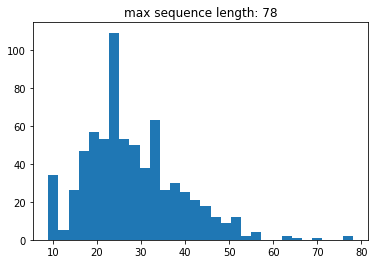

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}")

In [ ]:
max_ = max(train_sequence_lengths)

[link text](https://)The mapping can be introspected in the `tokenizer.vocab` attribute:

### Encoding the Dataset with the Tokenizer

Encoding the full train / valid and test sets with Bert tokenizer to get a padded integer numpy arrays:

In [ ]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

encoded_train = encode_dataset(tokenizer, df_train["words"], max_)
encoded_train["input_ids"]

array([[  101, 25930,  8625, ...,     0,     0,     0],
       [  101, 25930,  8625, ...,     0,     0,     0],
       [  101, 25930,  8625, ...,     0,     0,     0],
       ...,
       [  101,  9925, 13970, ...,     0,     0,     0],
       [  101,  5904, 13970, ...,     0,     0,     0],
       [  101,  6222, 13970, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], max_)
encoded_test = encode_dataset(tokenizer, df_test["words"], max_)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [ ]:
seq_out_tokenizer = Tokenizer(filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n', oov_token="UNK",lower=False)

In [ ]:
##Preprocessing
df_train.fillna('O',inplace = True)
df_valid.fillna('O',inplace = True)

In [ ]:
seq_out_tokenizer.fit_on_texts(df_train["word_labels"].tolist())

In [ ]:
seq_out_tokenizer.fit_on_texts(df_valid["word_labels"].tolist())

In [ ]:
seq_out_word_to_index = seq_out_tokenizer.word_index
len(seq_out_word_to_index)

105

In [ ]:
seq_out_word_to_index

{'UNK': 1,
 'O': 2,
 'B-kuva.umujyi_izina': 3,
 'B-kugera.umujyi_izina': 4,
 'I-kugenda_itariki.umunsi_izina': 5,
 'I-kugera.umujyi_izina': 6,
 'B-kugenda_itariki.umunsi_izina': 7,
 'I-kugenda_amasaha.amasaha_bijyanye': 8,
 'I-kuva.umujyi_izina': 9,
 'B-kugenda_amasaha.igihe_umunsi': 10,
 'B-kugenda_amasaha.amasaha_bijyanye': 11,
 'I-kugenda_kugaruka': 12,
 'B-indege_izina': 13,
 'I-kuhagera_amasaha.amasaha': 14,
 'I-kugenda_amasaha.igihe_umunsi': 15,
 'B-kugenda_kugaruka': 16,
 'I-indege_izina': 17,
 'B-kugenda_itariki.ukwezi_izina': 18,
 'B-kugenda_itariki.umunsi_umubare': 19,
 'B-umujyi_izina': 20,
 'I-ikibuga_izina': 21,
 'B-igiciro_guhuza': 22,
 'B-kode_sosiyete_indege': 23,
 'B-kuhagera_amasaha.amasaha': 24,
 'B-ifunguro': 25,
 'I-kuva.ikibuga_izina': 26,
 'B-kuguruka_guhagarara': 27,
 'B-kugera.leta_izina': 28,
 'B-kuhagera_amasaha.amasaha_bijyanye': 29,
 'B-kuguruka_mod': 30,
 'B-ikiciro_ubwoko': 31,
 'I-ikiciro_ubwoko': 32,
 'B-igiciro_kode': 33,
 'B-ikibuga_izina': 34,
 'I-um

In [ ]:
intent_names = set(df_train.intent_label)
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'kubutaka': 0,
 'indege_nta # atis_umurongo': 1,
 'indege_no': 2,
 'indege': 3,
 'umunsi_izina': 4,
 'ikibuga cyindege': 5,
 'ingano': 6,
 'kuguruka': 7,
 'amagambo ahinnye': 8,
 'intera': 9,
 'indege # atis_urumuri': 10,
 'indege # atis_airline': 11,
 'indege # atis_airfare': 12,
 'indege_igihe': 13,
 'ubushobozi': 14,
 'umujyi': 15,
 'ifunguro': 16}

In [ ]:
intent_train = df_train["intent_label"].map(intent_map).values
intent_valid = df_valid["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained mBERT model

Loading a pretrained mBERT base model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [ ]:
from transformers import TFAutoModel

base_bert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased")
base_bert_model.summary()

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_valid

{'input_ids': array([[  101, 12849,  2527, ...,     0,     0,     0],
        [  101, 12849,  2527, ...,     0,     0,     0],
        [  101, 12849,  2527, ...,     0,     0,     0],
        ...,
        [  101,  9925, 13970, ...,     0,     0,     0],
        [  101,  5904, 13970, ...,     0,     0,     0],
        [  101,  6222, 13970, ...,     0,     0,     0]], dtype=int32),
 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)}

In [ ]:
outputs = base_bert_model(encoded_valid)
len(outputs)

2

The **first ouput** of the mBERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [ ]:
outputs[0].shape

TensorShape([50, 78, 768])

The **second output** of the mBERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**.

In [ ]:
outputs[1].shape

TensorShape([50, 768])

#Mapping slots to the corresponding indexes

In [ ]:
slot_names = ["[PAD]"]
slot_names += list(seq_out_word_to_index.keys())[1:]
slot_names

['[PAD]',
 'O',
 'B-kuva.umujyi_izina',
 'B-kugera.umujyi_izina',
 'I-kugenda_itariki.umunsi_izina',
 'I-kugera.umujyi_izina',
 'B-kugenda_itariki.umunsi_izina',
 'I-kugenda_amasaha.amasaha_bijyanye',
 'I-kuva.umujyi_izina',
 'B-kugenda_amasaha.igihe_umunsi',
 'B-kugenda_amasaha.amasaha_bijyanye',
 'I-kugenda_kugaruka',
 'B-indege_izina',
 'I-kuhagera_amasaha.amasaha',
 'I-kugenda_amasaha.igihe_umunsi',
 'B-kugenda_kugaruka',
 'I-indege_izina',
 'B-kugenda_itariki.ukwezi_izina',
 'B-kugenda_itariki.umunsi_umubare',
 'B-umujyi_izina',
 'I-ikibuga_izina',
 'B-igiciro_guhuza',
 'B-kode_sosiyete_indege',
 'B-kuhagera_amasaha.amasaha',
 'B-ifunguro',
 'I-kuva.ikibuga_izina',
 'B-kuguruka_guhagarara',
 'B-kugera.leta_izina',
 'B-kuhagera_amasaha.amasaha_bijyanye',
 'B-kuguruka_mod',
 'B-ikiciro_ubwoko',
 'I-ikiciro_ubwoko',
 'B-igiciro_kode',
 'B-ikibuga_izina',
 'I-umujyi_izina',
 'B-kugenda_itariki.igihe_bijyanye',
 'I-kugenda_itariki.umwaka',
 'I-kugenda_itariki.umunsi_umubare',
 'B-kuva.

In [ ]:
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'O': 1,
 'B-kuva.umujyi_izina': 2,
 'B-kugera.umujyi_izina': 3,
 'I-kugenda_itariki.umunsi_izina': 4,
 'I-kugera.umujyi_izina': 5,
 'B-kugenda_itariki.umunsi_izina': 6,
 'I-kugenda_amasaha.amasaha_bijyanye': 7,
 'I-kuva.umujyi_izina': 8,
 'B-kugenda_amasaha.igihe_umunsi': 9,
 'B-kugenda_amasaha.amasaha_bijyanye': 10,
 'I-kugenda_kugaruka': 11,
 'B-indege_izina': 12,
 'I-kuhagera_amasaha.amasaha': 13,
 'I-kugenda_amasaha.igihe_umunsi': 14,
 'B-kugenda_kugaruka': 15,
 'I-indege_izina': 16,
 'B-kugenda_itariki.ukwezi_izina': 17,
 'B-kugenda_itariki.umunsi_umubare': 18,
 'B-umujyi_izina': 19,
 'I-ikibuga_izina': 20,
 'B-igiciro_guhuza': 21,
 'B-kode_sosiyete_indege': 22,
 'B-kuhagera_amasaha.amasaha': 23,
 'B-ifunguro': 24,
 'I-kuva.ikibuga_izina': 25,
 'B-kuguruka_guhagarara': 26,
 'B-kugera.leta_izina': 27,
 'B-kuhagera_amasaha.amasaha_bijyanye': 28,
 'B-kuguruka_mod': 29,
 'B-ikiciro_ubwoko': 30,
 'I-ikiciro_ubwoko': 31,
 'B-igiciro_kode': 32,
 'B-ikibuga_izina': 33,
 'I-u

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [ ]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, max_)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, max_)

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

#Joint Intent And Slot Filling Model

In [ ]:
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-multilingual-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        sequence_output, pooled_output = self.bert(inputs, training=training)

        # The first output of the main mBERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main mBERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

joint_model = JointIntentAndSlotFillingModel(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

In [ ]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [ ]:
#################   Saving Model Project  #########################
joint_model

In [ ]:
history = joint_model.fit(encoded_train, (slot_train, intent_train),validation_data=(encoded_valid, (slot_valid, intent_valid)), epochs=50, batch_size=5)

Epoch 1/50
140/140 [==============================] - 27s 121ms/step - loss: 1.9813 - output_1_loss: 0.6207 - output_2_loss: 1.3606 - output_1_accuracy: 0.8867 - output_2_accuracy: 0.6957 - val_loss: 1.7120 - val_output_1_loss: 0.3601 - val_output_2_loss: 1.3519 - val_output_1_accuracy: 0.9321 - val_output_2_accuracy: 0.6800
Epoch 2/50
140/140 [==============================] - 15s 107ms/step - loss: 1.5584 - output_1_loss: 0.2946 - output_2_loss: 1.2638 - output_1_accuracy: 0.9384 - output_2_accuracy: 0.7029 - val_loss: 1.6168 - val_output_1_loss: 0.2124 - val_output_2_loss: 1.4044 - val_output_1_accuracy: 0.9549 - val_output_2_accuracy: 0.6800
Epoch 3/50
140/140 [==============================] - 15s 108ms/step - loss: 1.4382 - output_1_loss: 0.2061 - output_2_loss: 1.2321 - output_1_accuracy: 0.9553 - output_2_accuracy: 0.7043 - val_loss: 1.3565 - val_output_1_loss: 0.1371 - val_output_2_loss: 1.2194 - val_output_1_accuracy: 0.9721 - val_output_2_accuracy: 0.6800
Epoch 4/50
140/140 

#Making prediction on a single text sequence and displaying both the sequence-wise and the token-wise class labels

In [ ]:

def show_predictions(text, tokenizer, model, intent_names, slot_names):
  
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    # print(inputs)
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    # print(outputs)
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    # print(slot_ids)
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    intent = [k for k, v in intent_names.items() if v == intent_id]

    # print(slot_ids)

    print("## Intent:", intent)
    print("## Slots:")
    slot_pred = []
    
    ####
    text_split = text.split(' ')
    tokens_ids = [(i,j) for i,j in zip(tokenizer.tokenize(text),slot_ids)]
    #### Removing ## Tokens
    tokens_ids_ = [x for x in tokens_ids if not '##' in x[0]]

    for token, slot_id in zip(text_split, tokens_ids_):

      print(f"{token} : {slot_names[slot_id[1]]}")

      slot_pred.append(slot_names[slot_id[1]])

    return intent, slot_pred

In [ ]:
def diplay_prediction(data,index):
  print('Actual sentence {sent}'.format(sent = data.iloc[index]["words"]))
  print('Actual Labels {sent}'.format(sent = data.iloc[index]["word_labels"]))
  print("_____________________________________________________________")
  print('predicted labels {labels}'.format(labels = show_predictions(data.iloc[index]["words"], tokenizer, joint_model, intent_map, slot_names)[1]))  


In [ ]:
diplay_prediction(df_train,5)

Actual sentence kuwa mbere mu gitondo nkeneye indege imvana columbus ikanjyana indianapolis
Actual Labels B-kugenda_itariki.umunsi_izina I-kugenda_itariki.umunsi_izina B-kugenda_amasaha.igihe_umunsi I-kugenda_amasaha.igihe_umunsi O O O B-kuva.umujyi_izina O B-kugera.umujyi_izina
_____________________________________________________________
## Intent: ['kuguruka']
## Slots:
kuwa : B-kugenda_itariki.umunsi_izina
mbere : I-kugenda_itariki.umunsi_izina
mu : B-kugenda_amasaha.igihe_umunsi
gitondo : I-kugenda_amasaha.igihe_umunsi
nkeneye : O
indege : O
imvana : O
columbus : B-kuva.umujyi_izina
ikanjyana : O
indianapolis : B-kugera.umujyi_izina
predicted labels ['B-kugenda_itariki.umunsi_izina', 'I-kugenda_itariki.umunsi_izina', 'B-kugenda_amasaha.igihe_umunsi', 'I-kugenda_amasaha.igihe_umunsi', 'O', 'O', 'O', 'B-kuva.umujyi_izina', 'O', 'B-kugera.umujyi_izina']


The same process followed above can apply for other languages 